In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
!pip install einops flash_attn


import numpy as np # linear algebra
import pandas as pd # data processing
import torch
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image, ImageDraw
import requests
import copy
from datasets import load_dataset
import os
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import ast

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [2]:
IMAGES_PATH = "/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images"
# Path to the captions
CAPTIONS_PATH = "/kaggle/input/flickr-image-dataset/flickr30k_images/results.csv"

# Fixed length allowed for any sequence
SEQ_LENGTH = 20

# Exploring the dataset

In [3]:
keywords = ['dog', 'cat','person','guy','child','pet','friend']

df = pd.read_csv(CAPTIONS_PATH, delimiter="|")

df.dropna(subset=['image_name', ' comment'], inplace=True)

for keyword in keywords:
    print(df[df[' comment'].str.contains(keyword)])

            image_name  comment_number  \
60      1001773457.jpg               0   
61      1001773457.jpg               1   
62      1001773457.jpg               2   
63      1001773457.jpg               3   
64      1001773457.jpg               4   
...                ...             ...   
158825   989851184.jpg               0   
158826   989851184.jpg               1   
158827   989851184.jpg               2   
158828   989851184.jpg               3   
158829   989851184.jpg               4   

                                                  comment  
60       A black dog and a white dog with brown spots ...  
61       A black dog and a tri-colored dog playing wit...  
62       Two dogs of different breeds looking at each ...  
63        Two dogs on pavement moving toward each other .  
64             A black dog and a spotted dog are fighting  
...                                                   ...  
158825   A black dog has a dumbbell in his mouth looki...  
158826   A blac

## Showing 5 images from each category

Keyword: dog
        image_name  comment_number  \
60  1001773457.jpg               0   
61  1001773457.jpg               1   
62  1001773457.jpg               2   
63  1001773457.jpg               3   
64  1001773457.jpg               4   

                                              comment  
60   A black dog and a white dog with brown spots ...  
61   A black dog and a tri-colored dog playing wit...  
62   Two dogs of different breeds looking at each ...  
63    Two dogs on pavement moving toward each other .  
64         A black dog and a spotted dog are fighting  


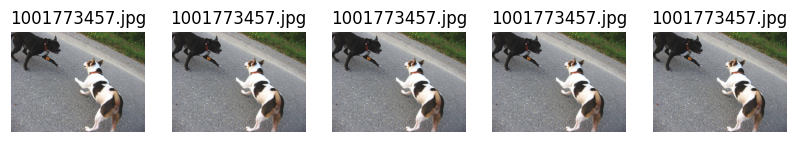

Keyword: cat
         image_name  comment_number  \
360  1019604187.jpg               0   
361  1019604187.jpg               1   
362  1019604187.jpg               2   
363  1019604187.jpg               3   
370  1020651753.jpg               0   

                                               comment  
360   A dog prepares to catch a thrown object in a ...  
361   A white dog is ready to catch a yellow ball f...  
362   A white dog is about to catch a yellow ball i...  
363   A white dog is about to catch a yellow dog toy .  
370   A white dog is trying to catch a ball in mida...  


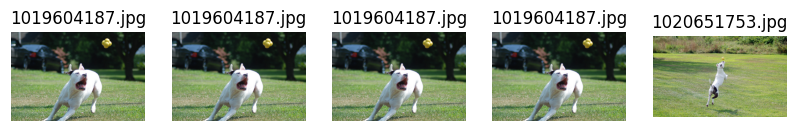

Keyword: person
        image_name  comment_number  \
100  100444898.jpg               0   
130  100716317.jpg               0   
131  100716317.jpg               1   
132  100716317.jpg               2   
183  101001624.jpg               3   

                                               comment  
100   A person in gray stands alone on a structure ...  
130   A person with long gray hair has a beret with...  
131   A person dressed in a blue coat is standing i...  
132   A person with gray hair is painting in a publ...  
183           A person riding a bike on a snowy road .  


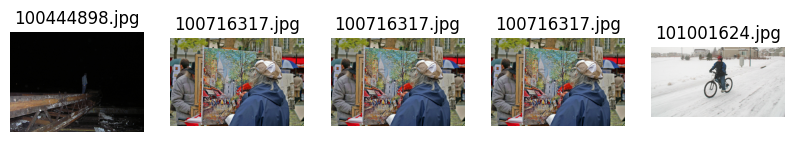

Keyword: guy
        image_name  comment_number  \
0   1000092795.jpg               0   
21  1000366164.jpg               1   
28  1000523639.jpg               3   
49  1001545525.jpg               4   
56  1001633352.jpg               1   

                                              comment  
0    Two young guys with shaggy hair look at their...  
21   Two guy cooking and joking around with the ca...  
28           a guy stitching up another man 's coat .  
49              two guys jumping over a gate together  
56   Four casually dressed guys jumping down a sta...  


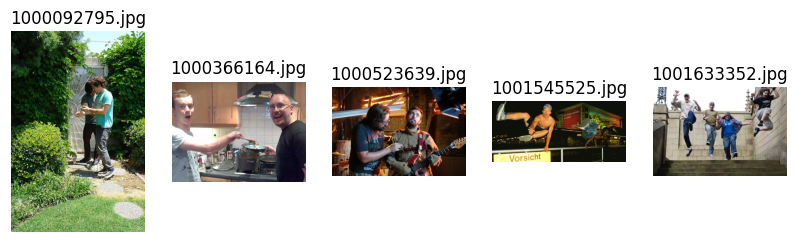

Keyword: child
         image_name  comment_number  \
10   1000268201.jpg               0   
115  1006452823.jpg               0   
116  1006452823.jpg               1   
117  1006452823.jpg               2   
140  1007320043.jpg               0   

                                               comment  
10    A child in a pink dress is climbing up a set ...  
115   two children , a girl and a boy are practicin...  
116   Two children sit on a small seesaw in the sand .  
117          Two children sitting on a teeter totter .  
140   A small child grips onto the red ropes at the...  


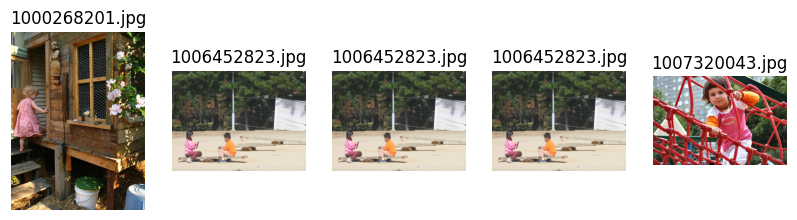

Keyword: pet
          image_name  comment_number  \
261    101362650.jpg               1   
467   1027211271.jpg               2   
820    105493628.jpg               0   
974   1065831604.jpg               4   
1143  1080230428.jpg               3   

                                                comment  
261    A boy jump kicking over three kids kicking wo...  
467    This person is performing a trick in skateboa...  
820    White wine and appetizers on are displayed in...  
974      Several bike riders compete in a competition .  
1143   Volleyball players compete on a sunny day at ...  


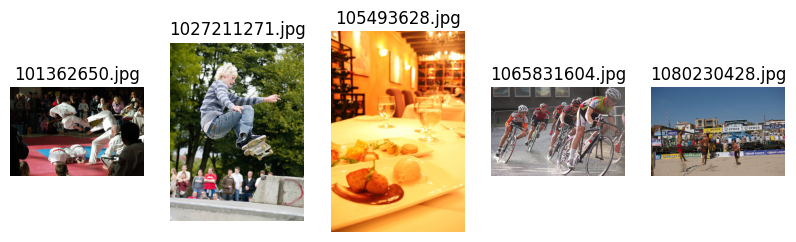

Keyword: friend
          image_name  comment_number  \
4     1000092795.jpg               4   
1350  1094283901.jpg               0   
1630  1106644976.jpg               0   
2283  1145781754.jpg               3   
2284  1145781754.jpg               4   

                                                comment  
4               Two friends enjoy time spent together .  
1350   A shirtless man jumping off a large concrete ...  
1630   A young group of friends adorned with face pa...  
2283       A group of friends converse around a table .  
2284           A group of friends talk around a table .  


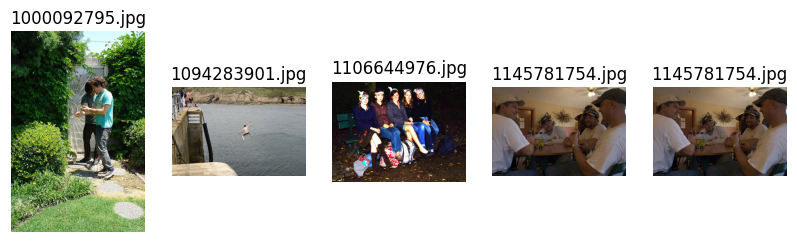

In [4]:
# Function to display images
def display_images(image_paths):
    plt.figure(figsize=(10, 10))
    for i, image_path in enumerate(image_paths):
        try:
            image = Image.open(image_path)
            plt.subplot(1, 5, i + 1)
            plt.imshow(image)
            plt.axis('off')
            plt.title(os.path.basename(image_path))
        except Exception as e:
            print(f"Error opening image {image_path}: {e}")
    plt.show()

# Filter the DataFrame based on the keywords and display 5 images each
for keyword in keywords:
    filtered_records = df[df[' comment'].str.contains(keyword)].head(5)
    print(f"Keyword: {keyword}")
    print(filtered_records)

    # Get the image paths for the filtered records
    image_paths = [os.path.join(IMAGES_PATH, img_name.strip()) for img_name in filtered_records['image_name']]
    
    # Display the images
    display_images(image_paths)

In [6]:
# Clean up 'image_name' and ' comment' columns
df['image_name'] = df['image_name'].str.strip().str.lower()  # Ensure no extra spaces or case differences
df[' comment'] = df[' comment'].str.strip().str.lower()  # Normalize the comments

# Remove any potential non-printable characters
df['image_name'] = df['image_name'].apply(lambda x: ''.join(c for c in x if c.isprintable()))
df[' comment'] = df[' comment'].apply(lambda x: ''.join(c for c in x if c.isprintable()))

# Ensure image names have consistent extensions
df['image_name'] = df['image_name'].apply(lambda x: x if x.endswith('.jpg') else x + '.jpg')


## **We see duplicates so lets remove and show again**

Duplicates before removal:
            image_name  comment_number  \
0       1000092795.jpg               0   
1       1000092795.jpg               1   
2       1000092795.jpg               2   
3       1000092795.jpg               3   
4       1000092795.jpg               4   
...                ...             ...   
158910   998845445.jpg               0   
158911   998845445.jpg               1   
158912   998845445.jpg               2   
158913   998845445.jpg               3   
158914   998845445.jpg               4   

                                                  comment  
0       two young guys with shaggy hair look at their ...  
1       two young , white males are outside near many ...  
2        two men in green shirts are standing in a yard .  
3            a man in a blue shirt standing in a garden .  
4                 two friends enjoy time spent together .  
...                                                   ...  
158910  a man in shorts and a hawaiian shirt lea

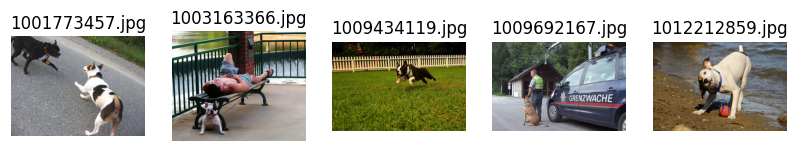

Keyword: cat


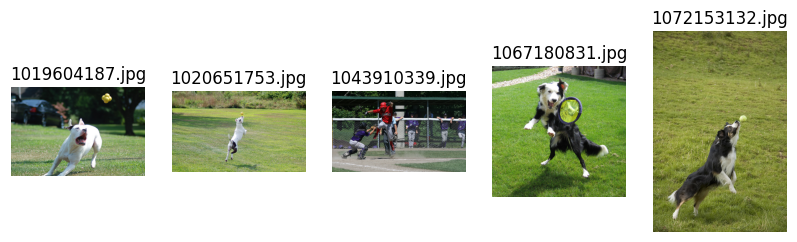

Keyword: person


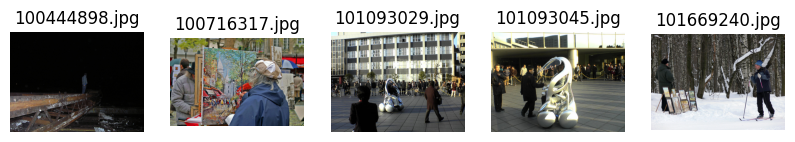

Keyword: guy


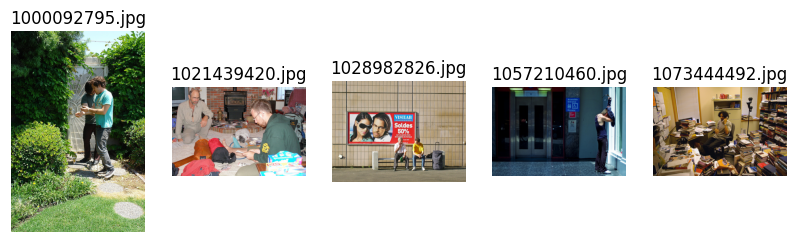

Keyword: child


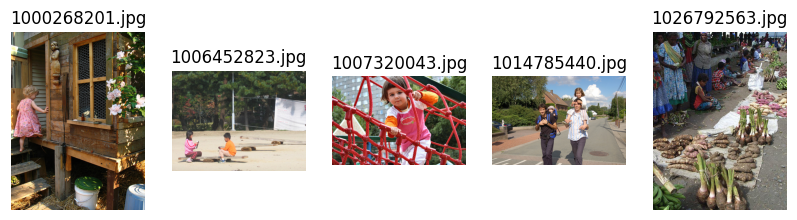

Keyword: pet


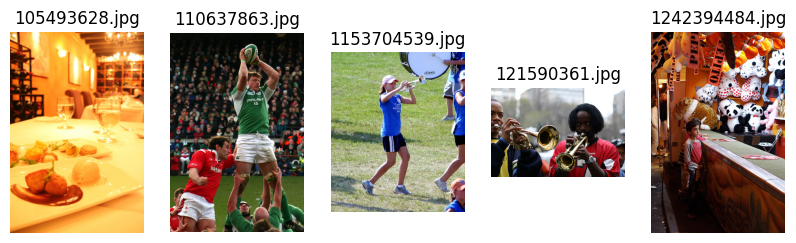

Keyword: friend


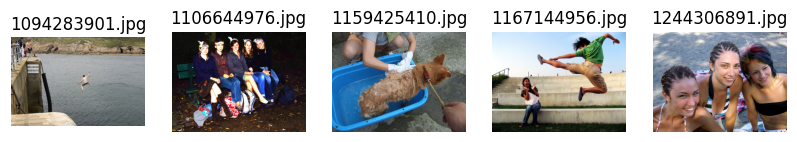

In [7]:
# Check for duplicates before removing
print("Duplicates before removal:")
print(df[df.duplicated(subset=['image_name'], keep=False)])

# Remove exact duplicates
df.drop_duplicates(subset=['image_name'], keep='first', inplace=True)

# Check for remaining duplicates
print("Duplicates after removal:")
print(df[df.duplicated(subset=['image_name'], keep=False)])

for keyword in keywords:
    filtered_records = df[df[' comment'].str.contains(keyword)].head(5)
    print(f"Keyword: {keyword}")
    
    # Get the image paths for the filtered records
    image_paths = [os.path.join(IMAGES_PATH, img_name.strip()) for img_name in filtered_records['image_name']]
    
    # Display the images
    display_images(image_paths)

In [8]:
print(df.columns)

Index(['image_name', ' comment_number', ' comment'], dtype='object')


In [10]:
common_image_names = set() #initialize set for checking unique records 
keyword_dfs = {}
    
# Add start and end tokens to each caption
df[' comment'] = "<start> " + df[' comment'].str.strip() + " <end>"
    
# Remove captions that are either too short or too long
df['caption_length'] = df[' comment'].str.split().apply(len)
df = df[(df['caption_length'] >= 4) & (df['caption_length'] <= SEQ_LENGTH)]
df.drop(columns=['caption_length'], inplace=True)
    
# Create the full image path
df['image_path'] = df['image_name'].apply(lambda x: os.path.join(IMAGES_PATH, x.strip()))
    
  
    
for keyword in keywords:
    # Filter records containing the keyword
    keyword_filtered_df = df[df[' comment'].str.contains(keyword, na=False)]

    # Ensure there are at least `min_records` records
    if len(keyword_filtered_df) >= 800:
            keyword_filtered_df = keyword_filtered_df.head(800)
            keyword_dfs[keyword] = keyword_filtered_df
            
    common_image_names.update(keyword_filtered_df['image_name'].unique())        
    # Append to the result DataFrame
    
    # Print the number of records for the keyword
    print(f"Keyword: {keyword}")
    print(f"Number of records: {len(keyword_filtered_df)}")
    
    
# Find common records across all keywords
common_records_df = df[df['image_name'].isin(common_image_names)]

# Filter to keep only those records with at least `min_records` for each keyword
final_filtered_df = pd.DataFrame()
for keyword, k_df in keyword_dfs.items():
     final_filtered_df = pd.concat([final_filtered_df, k_df])

# Drop duplicates if any
df = final_filtered_df.drop_duplicates(subset=['image_name', ' comment'])

 

print(f"Total number of samples: {len(df)}")
for path in df["image_path"][:5]:
    print(path)

Keyword: dog
Number of records: 800
Keyword: cat
Number of records: 233
Keyword: person
Number of records: 625
Keyword: guy
Number of records: 154
Keyword: child
Number of records: 800
Keyword: pet
Number of records: 136
Keyword: friend
Number of records: 57
Total number of samples: 1599
/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/1003163366.jpg
/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/1009434119.jpg
/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/1009692167.jpg
/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/1012212859.jpg
/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/1015584366.jpg


/tmp/ipykernel_387/985925013.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['caption_length'], inplace=True)
/tmp/ipykernel_387/985925013.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['image_path'] = df['image_name'].apply(lambda x: os.path.join(IMAGES_PATH, x.strip()))


In [11]:
model_id = 'microsoft/Florence-2-large'
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True, torch_dtype='auto').eval().cuda()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model = model.half() #ensure float16 presicion

config.json:   0%|          | 0.00/2.44k [00:00<?, ?B/s]

configuration_florence2.py:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_florence2.py:   0%|          | 0.00/127k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- modeling_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


generation_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [13]:
min_object_size = (50, 50)  # Minimum size of bounding boxes
max_object_size = (300, 300)  # Maximum size of bounding boxes
min_image_size = (256, 256)  # Minimum size of images
max_image_size = (1024, 1024)  # Maximum size of images

def resize_image(image):
    # Resize the image to a size within the defined degrees of freedom
    image = image.resize((min(max(image.size[0], min_image_size[0]), max_image_size[0]),
                          min(max(image.size[1], min_image_size[1]), max_image_size[1])))
    return image

In [42]:
def run_example(image,task_prompt, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt").to('cuda', torch.float16)
    generated_ids = model.generate(
      input_ids=inputs["input_ids"].cuda(),
      pixel_values=inputs["pixel_values"].cuda(),
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text, 
        task=task_prompt, 
        image_size=(image.width, image.height)
    )

    return parsed_answer

In [23]:
text_prompt = '<OD>'
image=Image.open("/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/1009692167.jpg")
result=run_example(text_prompt)

result['<OD>']

{'bboxes': [[201.75, 8.82450008392334, 499.25, 332.5005187988281],
  [109.75, 197.30250549316406, 212.25, 316.8495178222656],
  [123.25, 222.27749633789062, 143.25, 232.6005096435547],
  [427.75, 174.9915008544922, 464.75, 183.9824981689453],
  [129.75, 103.0634994506836, 193.25, 298.86749267578125],
  [58.75, 150.6824951171875, 71.75, 163.00350952148438],
  [149.25, 128.3715057373047, 191.75, 176.989501953125]],
 'labels': ['car',
  'dog',
  'dog collar',
  'door handle',
  'person',
  'stop sign',
  'vestment']}

In [43]:
def create_annotations(image, comment, model, processor, device):
    # Process the image
    inputs = processor(images=image, return_tensors="pt")
    
    # Move image tensor to the device and convert to float16
    pixel_values = inputs['pixel_values'].to(device).half()
    
    # Process text
    text_inputs = processor(text=comment, return_tensors="pt")
    input_ids = text_inputs['input_ids'].to(device)
    attention_mask = text_inputs['attention_mask'].to(device)
    
    # Perform the forward pass with both image and text inputs
    outputs = model(pixel_values=pixel_values, input_ids=input_ids, attention_mask=attention_mask)
    
    # Extract bounding boxes and labels
    logits = outputs.logits
    bboxes = logits.softmax(-1).argmax(-1).tolist()
    labels = outputs.labels.tolist()
    
    return bboxes, labels

def filter_and_resize_annotations(bboxes, labels, min_object_size, max_object_size):
    filtered_bboxes = []
    filtered_labels = []
    
    for bbox, label in zip(bboxes, labels):
        width, height = bbox[2] - bbox[0], bbox[3] - bbox[1]
        if min_object_size[0] <= width <= max_object_size[0] and min_object_size[1] <= height <= max_object_size[1]:
            filtered_bboxes.append(bbox)
            filtered_labels.append(label)
    
    return filtered_bboxes, filtered_labels


def get_comment_and_image_path(image_path):
    matching_rows = df[df['image_name'] == image_path]
    if matching_rows.empty:
        print(f"No matching entry for image path {image_path}")
        return None, None
    comments = matching_rows['comment'].tolist()[0]
    if comments:
        combined_comment = ' '.join(comments)  # Combine comments into a single string
        return combined_comment, filename
    else:
        return None, filename

def process_images_in_directory(directory, model, processor, device):
    annotations = []
    counter = 0 #counter to print limited number of records
    
    # Get the base filenames from the dataset
    image_paths_from_dataset = df['image_path'].apply(lambda x: os.path.basename(x)).unique()
    
    for dirname, _, filenames in os.walk(directory):
        for filename in filenames:
            if filename.endswith('.jpg'):  # Only process JPG images
                # Get the base filename (e.g., '2715746315.jpg')
                image_filename = filename
                
                #Construct image path
                image_path = os.path.join(dirname, filename)
                
                # Check if the filename exists in the dataset
                if image_filename in image_paths_from_dataset:
                    # Find the row(s) in the dataset matching the filename
                    matching_rows = df[df['image_path'].apply(lambda x: os.path.basename(x)) == image_filename]

                    # Continue processing if necessary
                    image = Image.open(image_path)
                    image = resize_image(image)
                    
                    # Call your object detection function or any other processing here
                    data = run_example(image,'<OD>')
                    
                    # Initialize filtered_bboxes and filtered_labels for each image
                    filtered_bboxes = []
                    filtered_labels = []

                    for bbox, label in zip(data['<OD>']['bboxes'], data['<OD>']['labels']):
                        width, height = bbox[2] - bbox[0], bbox[3] - bbox[1]
                        if min_object_size[0] <= width <= max_object_size[0] and min_object_size[1] <= height <= max_object_size[1]:
                            filtered_bboxes.append(bbox)
                            filtered_labels.append(label)
                    
                    # Add annotations for the current image
                    annotations.append({'image_path': image_path, 'bboxes': filtered_bboxes, 'labels': filtered_labels})
                    
                    if counter < 100:
                        print(f"Image: {image_filename}, Labels: {data['<OD>']['labels']}")
                        counter += 1
     # Convert list to DataFrame
    annotations = pd.DataFrame(annotations, columns=['image_path', 'bboxes', 'labels'])
    return annotations


In [44]:
# Directory containing the images
image_directory = '/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images'


# Process all images in the directory to get annotations
annotations_df = process_images_in_directory(image_directory, model, processor, torch.device("cuda"))

#Save DataFrame to CSV
annotations_df.to_csv('annotations.csv', index=False)

def split_dataset(annotations, train_ratio=0.8):
    num_train = int(len(annotations) * train_ratio)
    random.shuffle(annotations)
    train_annotations = annotations[:num_train]
    val_annotations = annotations[num_train:]
    
    return train_annotations, val_annotations








Image: 268704620.jpg, Labels: ['dog', 'dog']
Image: 2673564214.jpg, Labels: ['person', 'person', 'person', 'person']
Image: 2094323311.jpg, Labels: ['dog', 'dog collar', 'person', 'tag']
Image: 2782433864.jpg, Labels: ['dog', 'dog', 'dog', 'dog collar']
Image: 2744615692.jpg, Labels: ['person', 'sandal', 'swimwear']
Image: 2267682214.jpg, Labels: ['bottle', 'bottle cap', 'dog']
Image: 2739180469.jpg, Labels: ['frisbee', 'person', 'swimwear']
Image: 284279868.jpg, Labels: ['dog', 'dog']
Image: 1478606153.jpg, Labels: ['dog']
Image: 4515264823.jpg, Labels: ['boy', 'boy', 'boy', 'girl', 'girl', 'girl', 'swimming pool', 'swimming pool', 'swimwear', 'swimwear', 'swimwear', 'swimwear', 'swimwear', 'swimwear', 'swimwear']
Image: 2284894733.jpg, Labels: ['awning', 'dog', 'person', 'person', 'person']
Image: 2199932695.jpg, Labels: ['person']
Image: 2434006663.jpg, Labels: ['dog', 'dog']
Image: 125635185.jpg, Labels: ['boy', 'footwear', 'girl', 'girl', 'human face']
Image: 2469351714.jpg, Label

In [5]:
labels_df = pd.read_csv("/kaggle/input/new-labeling/annotations_new1.csv")
labels_df.head()

image_path  \
0  /kaggle/input/flickr-image-dataset/flickr30k_i...   
1  /kaggle/input/flickr-image-dataset/flickr30k_i...   
2  /kaggle/input/flickr-image-dataset/flickr30k_i...   
3  /kaggle/input/flickr-image-dataset/flickr30k_i...   
4  /kaggle/input/flickr-image-dataset/flickr30k_i...   

                                              bboxes                    labels  
0  [[77.75, 46.5885009765625, 239.25, 233.6564941...            ['dog', 'dog']  
1  [[301.25, 116.4375, 416.75, 247.3125], [212.25...      ['person', 'person']  
2  [[78.75, 278.8125, 185.75, 361.3125], [266.25,...  ['dog collar', 'person']  
3  [[221.75, 88.60750579833984, 418.75, 261.80252...     ['dog', 'dog', 'dog']  
4                                                 []                        []

In [8]:
labels_df.columns


Index(['image_path', 'bboxes', 'labels'], dtype='object')

# Convert the created dataset to 2 labels: "person" , "dog"

In [12]:
import ast

# Define the classes to include
target_classes = {'person': ['person', 'human', 'man', 'guy', 'boy', 'woman', 'girl', 'lady', 'child', 'kid', 
                             'toddler', 'baby', 'infant', 'adult', 'teen', 'teenager'],
                  'pet': ['dog', 'puppy', 'canine', 'cat', 'kitten', 'feline']}

# Function to map labels to "person" or "pet"
def map_labels(label):
    for key, values in target_classes.items():
        if any(value in label.lower() for value in values):
            return key
    return None

# Function to filter bounding boxes and labels
def filter_bboxes_and_labels(row):
    bboxes = ast.literal_eval(row['bboxes'])
    labels = ast.literal_eval(row['labels'])
    
    filtered_bboxes = []
    filtered_labels = []
    
    for bbox, label in zip(bboxes, labels):
        mapped_label = map_labels(label)
        if mapped_label:
            filtered_bboxes.append(bbox)
            filtered_labels.append(mapped_label)
    
    return filtered_bboxes, filtered_labels

# Apply the function to filter the dataset
filtered_data = labels_df.apply(lambda row: filter_bboxes_and_labels(row), axis=1)

# Create new columns for filtered bboxes and labels
labels_df['filtered_bboxes'] = filtered_data.apply(lambda x: x[0])
labels_df['filtered_labels'] = filtered_data.apply(lambda x: x[1])

# Remove rows without any valid bounding boxes
labels_df = labels_df[labels_df['filtered_bboxes'].apply(len) > 0]

# Select only the relevant columns
filtered_df = labels_df[['image_path', 'filtered_bboxes', 'filtered_labels']].rename(
    columns={'filtered_bboxes': 'bboxes', 'filtered_labels': 'labels'}
)

# Save the updated dataset to a new CSV file
filtered_df.to_csv('filtered_annotations.csv', index=False)



/tmp/ipykernel_35/1431221422.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels_df['filtered_bboxes'] = filtered_data.apply(lambda x: x[0])
/tmp/ipykernel_35/1431221422.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels_df['filtered_labels'] = filtered_data.apply(lambda x: x[1])


image_path  \
0  /kaggle/input/flickr-image-dataset/flickr30k_i...   
1  /kaggle/input/flickr-image-dataset/flickr30k_i...   
2  /kaggle/input/flickr-image-dataset/flickr30k_i...   
3  /kaggle/input/flickr-image-dataset/flickr30k_i...   
6  /kaggle/input/flickr-image-dataset/flickr30k_i...   

                                              bboxes            labels  
0  [[77.75, 46.5885009765625, 239.25, 233.6564941...        [pet, pet]  
1  [[301.25, 116.4375, 416.75, 247.3125], [212.25...  [person, person]  
2  [[78.75, 278.8125, 185.75, 361.3125], [266.25,...     [pet, person]  
3  [[221.75, 88.60750579833984, 418.75, 261.80252...   [pet, pet, pet]  
6  [[218.2689971923828, 198.75, 273.0449829101562...          [person]

In [13]:
# Display the first few rows of the updated dataset
print(filtered_df.head())
print(filtered_df.shape)



                                          image_path  \
0  /kaggle/input/flickr-image-dataset/flickr30k_i...   
1  /kaggle/input/flickr-image-dataset/flickr30k_i...   
2  /kaggle/input/flickr-image-dataset/flickr30k_i...   
3  /kaggle/input/flickr-image-dataset/flickr30k_i...   
6  /kaggle/input/flickr-image-dataset/flickr30k_i...   

                                              bboxes            labels  
0  [[77.75, 46.5885009765625, 239.25, 233.6564941...        [pet, pet]  
1  [[301.25, 116.4375, 416.75, 247.3125], [212.25...  [person, person]  
2  [[78.75, 278.8125, 185.75, 361.3125], [266.25,...     [pet, person]  
3  [[221.75, 88.60750579833984, 418.75, 261.80252...   [pet, pet, pet]  
6  [[218.2689971923828, 198.75, 273.0449829101562...          [person]  
(2500, 3)


Total images: 2248
Total bounding boxes: 4356
Total 'person' labels: 2846
Total 'pet' labels: 1510


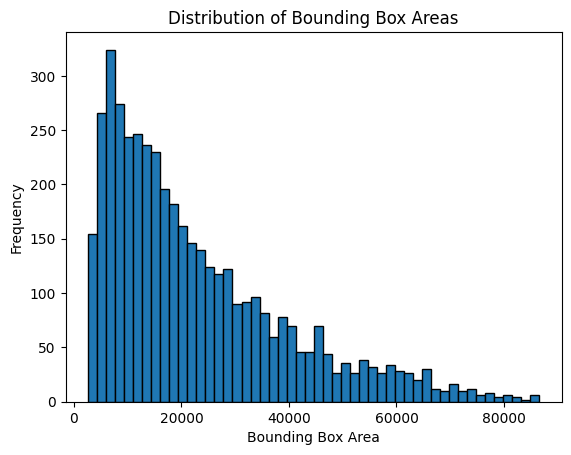

In [18]:
# Ensure that the 'bboxes' and 'labels' columns are lists
def ensure_list(x):
    if isinstance(x, str):
        return ast.literal_eval(x)
    return x

labels_df['bboxes'] = labels_df['bboxes'].apply(ensure_list)
labels_df['labels'] = labels_df['labels'].apply(ensure_list)

# Create a DataFrame with labels to simplify processing
labels_df = pd.DataFrame({
    'image_path': labels_df['image_path'],
    'bboxes': labels_df['bboxes'],
    'labels': labels_df['labels']
})

# Function to filter bounding boxes and labels based on the given classes
def filter_bboxes_and_labels(row):
    bboxes = row['bboxes']
    labels = row['labels']

    filtered_bboxes = []
    filtered_labels = []

    for bbox, label in zip(bboxes, labels):
        if label.lower() in ['person', 'girl', 'guy']:
            filtered_bboxes.append(bbox)
            filtered_labels.append('person')
        elif label.lower() in ['pet', 'dog', 'cat']:
            filtered_bboxes.append(bbox)
            filtered_labels.append('pet')

    return filtered_bboxes, filtered_labels

# Apply the function to filter the dataset
filtered_data = labels_df.apply(lambda row: filter_bboxes_and_labels(row), axis=1)

# Create new columns for filtered bboxes and labels
labels_df['filtered_bboxes'] = filtered_data.apply(lambda x: x[0])
labels_df['filtered_labels'] = filtered_data.apply(lambda x: x[1])

# Create a new DataFrame with filtered data
filtered_df = labels_df[['image_path', 'filtered_bboxes', 'filtered_labels']]

# Remove entries without any bounding boxes after filtering
filtered_df = filtered_df[filtered_df['filtered_bboxes'].apply(len) > 0]

# Save the filtered dataset to a new CSV file
filtered_df.to_csv('filtered_annotations.csv', index=False)

# Display basic statistics
print(f"Total images: {filtered_df['image_path'].nunique()}")
print(f"Total bounding boxes: {filtered_df['filtered_bboxes'].apply(len).sum()}")
print(f"Total 'person' labels: {filtered_df['filtered_labels'].apply(lambda x: x.count('person')).sum()}")
print(f"Total 'pet' labels: {filtered_df['filtered_labels'].apply(lambda x: x.count('pet')).sum()}")

# Plot the distribution of bounding box areas
def bbox_area(bbox):
    return (bbox[2] - bbox[0]) * (bbox[3] - bbox[1])

# Flatten the list of bounding boxes and calculate their areas
all_bboxes = filtered_df['filtered_bboxes'].explode().dropna().apply(lambda x: ast.literal_eval(str(x)))
all_bbox_areas = all_bboxes.apply(bbox_area)

# Plot the distribution of bounding box areas
plt.hist(all_bbox_areas, bins=50, edgecolor='k')
plt.xlabel('Bounding Box Area')
plt.ylabel('Frequency')
plt.title('Distribution of Bounding Box Areas')
plt.show()

In [16]:
labeled_df = pd.read_csv("/kaggle/input/labeled-dataset/filtered_annotations.csv")
labeled_df.head(10)
print(labeled_df.columns)

Index(['image_path', 'bboxes', 'labels'], dtype='object')


## Showing the new dataset Bounding Boxes example

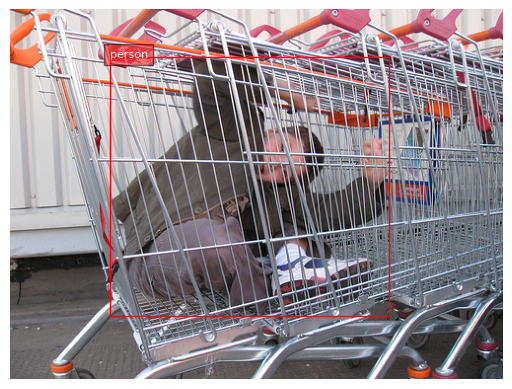

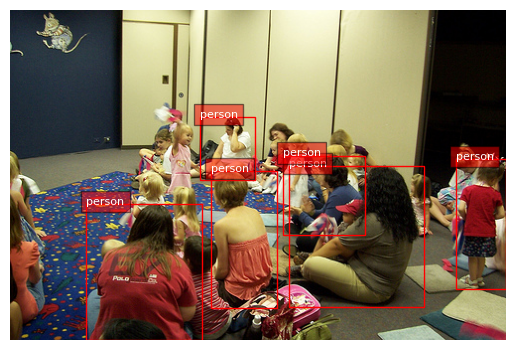

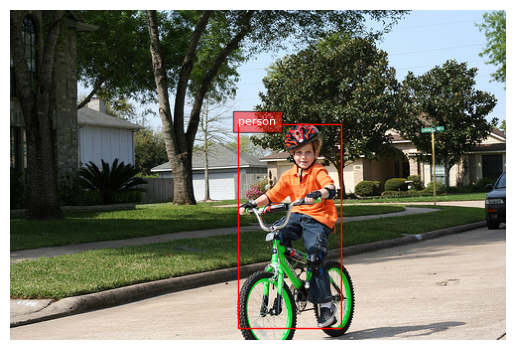

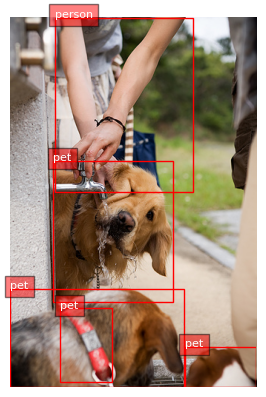

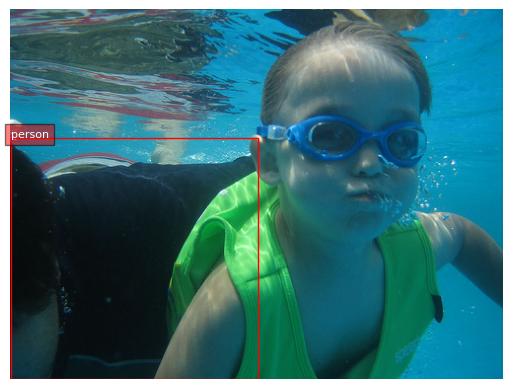

In [19]:

# Plot some images from the dataset
sampled_df = labeled_df.sample(n=5)  # Sample 5 images to display

for _, row in sampled_df.iterrows():
    image = Image.open(row['image_path'])
    bbox = eval(row['bboxes'])
    labels = eval(row['labels'])
    data = {
        'bboxes': bbox,
        'labels': labels
    }
    plot_bbox(image,data)

# Converting Dataset to YOLO format e.g "yaml"

In [26]:
# Load the filtered dataset
filtered_df = pd.read_csv('/kaggle/input/labeled-dataset/filtered_annotations.csv')

# Convert bounding boxes to YOLO format
def convert_to_yolo_format(image_size, bbox):
    dw = 1. / image_size[0]
    dh = 1. / image_size[1]
    x = (bbox[0] + bbox[2]) / 2.0
    y = (bbox[1] + bbox[3]) / 2.0
    w = bbox[2] - bbox[0]
    h = bbox[3] - bbox[1]
    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return (x, y, w, h)

# Create directories for YOLO dataset

os.makedirs('/kaggle/working/yolo_dataset', exist_ok=True)
os.makedirs('/kaggle/working/yolo_dataset/train/images', exist_ok=True)
os.makedirs('/kaggle/working/yolo_dataset/train/labels', exist_ok=True)
os.makedirs('/kaggle/working/yolo_dataset/val/images', exist_ok=True)
os.makedirs('/kaggle/working/yolo_dataset/val/labels', exist_ok=True)

# Split the dataset into training and validation sets
train_ratio = 0.8
val_ratio = 1 - train_ratio
train_df = filtered_df.sample(frac=train_ratio, random_state=42)
val_df = filtered_df.drop(train_df.index)

def save_yolo_annotations(df, subset):
    for _, row in df.iterrows():
        image_path = row['image_path']
        bboxes = ast.literal_eval(row['filtered_bboxes'])
        labels = ast.literal_eval(row['filtered_labels'])

        # Load the image to get its dimensions
        image = Image.open(image_path)
        image_size = image.size

        # Create YOLO format annotation file
        annotation_content = ""
        for bbox, label in zip(bboxes, labels):
            if label == 'person':
                class_id = 0
            elif label == 'pet':
                class_id = 1
            else:
                continue
            yolo_bbox = convert_to_yolo_format(image_size, bbox)
            annotation_content += f"{class_id} {' '.join(map(str, yolo_bbox))}\n"

        # Save the image and annotation file to the respective directories
        image_filename = os.path.basename(image_path)
        image.save(f'/kaggle/working/yolo_dataset/{subset}/images/{image_filename}')
        
        annotation_filename = os.path.splitext(image_filename)[0] + '.txt'
        with open(f'/kaggle/working/yolo_dataset/{subset}/labels/{annotation_filename}', 'w') as f:
            f.write(annotation_content)

# Save annotations for training and validation sets
save_yolo_annotations(train_df, 'train')
save_yolo_annotations(val_df, 'val')

# Create the YAML configuration file
yaml_content = f"""
train: /kaggle/working/yolo_dataset/train/images
val: /kaggle/working/yolo_dataset/val/images

nc: 2
names: ['person', 'pet']
"""

with open('/kaggle/working/yolo_dataset/data.yaml', 'w') as f:
    f.write(yaml_content)

print("YOLO dataset and configuration file created successfully!")

YOLO dataset created successfully!


# TTA(test time augmentations) correctness explanation 

To ensure the correctness of annotations using Test Time Augmentation (TTA), one can apply various augmentations (such as horizontal flips, vertical flips, random rotations, and color jittering) to each image in the test set and pass these augmented images through the FLORENCE2 model to obtain predictions. By aggregating the predictions from all augmented versions of an image, such as averaging bounding box coordinates, we can achieve a more robust and consistent set of predictions. These aggregated predictions can then be compared to the original annotations using metrics like Intersection over Union (IoU) to identify discrepancies. If the IoU between the predicted and original bounding boxes is consistently high, it indicates that the annotations are likely correct; otherwise, potential errors in the annotations can be flagged for further review. This method leverages the model's ability to generalize across augmented inputs to validate the quality of the annotations.

# Ensamble

Ensembles can be used to check the correctness of annotations by combining predictions from multiple models trained on the same dataset. By using an ensemble of diverse models with different architectures or trained with different hyperparameters, we can achieve a more comprehensive understanding of the annotation quality. Each model in the ensemble makes predictions on the training images, and these predictions are aggregated, typically by averaging bounding box coordinates or using majority voting for classification labels. By comparing the ensemble's aggregated predictions to the original annotations, we can identify inconsistencies. If the ensemble consistently predicts bounding boxes and labels that closely match the original annotations, this indicates high annotation quality. Conversely, significant deviations between the ensemble's predictions and the original annotations can highlight potential errors, prompting further investigation and refinement of the annotations. This approach leverages the collective strength and diversity of multiple models to provide a more reliable assessment of annotation correctness.

# Decision regarding degrees of freedom


When establishing criteria for a dataset, such as minimum and maximum object sizes and image sizes, it's crucial to balance flexibility and constraints to ensure the quality and consistency of the data. Here’s a breakdown of the decisions regarding degrees of freedom:

**Minimum Object Size (min_object_size = (50, 50)):**

Setting a minimum size for bounding boxes helps ensure that the objects being detected are sufficiently large to contain meaningful information. Objects smaller than this threshold might be too small for accurate detection and classification, potentially leading to poor model performance. This constraint filters out noise and focuses on objects that are more likely to be correctly annotated and recognized by the model.

**Maximum Object Size (max_object_size = (300, 300)):**

Defining a maximum object size ensures that the objects being detected are not excessively large relative to the image. Extremely large objects might dominate the image, reducing the model's ability to detect smaller objects in the same image. This constraint helps maintain a balance, ensuring that the dataset contains a variety of object sizes for more robust model training.

**Minimum Image Size (min_image_size = (256, 256)):**

Setting a minimum size for images ensures that each image has sufficient resolution for the model to extract meaningful features. Images smaller than this threshold might lack detail, making it difficult for the model to learn and detect objects accurately. This constraint ensures that all images have a baseline level of quality.

**Maximum Image Size (max_image_size = (1024, 1024)):**

Defining a maximum image size helps manage computational resources and processing times. Extremely large images can be computationally expensive to process and might not provide proportional benefits in terms of feature extraction and object detection accuracy. This constraint ensures that the dataset is manageable and that the images are of a consistent, reasonable size for efficient model training and evaluation.
These decisions regarding degrees of freedom strike a balance between ensuring data quality and maintaining flexibility. They help filter out unsuitable data while retaining a diverse range of object and image sizes, ultimately leading to more effective and efficient model training.